In [1]:
import sys
sys.path.append('..')

In [2]:
import yaml
import os
import glob
import torch

training_rootdir = '/group/jug/ashesh/training/diffsplit/'

def model_checkpoint_fpath(fname=None):
    ckpt_dir = os.path.join(training_rootdir, ckpt, 'checkpoint')
    if fname is not None:
        return os.path.join(training_rootdir, ckpt, fname)
    else:
        list_of_files = glob.glob(ckpt_dir +'/*_gen.pth') # * means all if need specific format then *.csv
        latest_file = max(list_of_files, key=os.path.getctime)
        fname = latest_file
        return os.path.join(ckpt_dir,latest_file)

def model_checkpoint_fpath_prefix(fname=None):
    fpath = model_checkpoint_fpath(fname)
    suffix = '_gen.pth'
    assert fpath.endswith(suffix)
    return fpath[:-len(suffix)]

def load_config(ckpt):
    config_path = os.path.join(training_rootdir,ckpt,'wandb/latest-run/files/config.yaml')

    with open(config_path) as stream:
        try:
            opt = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
    
    keys = ["name","phase","gpu_ids","path","datasets","model","train"]
    return {k: opt[k]['value'] for k in keys}

In [3]:
from model.ddpm_modules.time_predictor import TimePredictor
from split import get_datasets
import os

classifier_ckpt = '/group/jug/ashesh/training/diffsplit/2410/Hagen-UnetClassifier-l2/8'

opt = load_config(classifier_ckpt)
model_opt = opt['model']
model = TimePredictor(
    in_channel=model_opt['unet']['in_channel'],
    out_channel=model_opt['unet']['out_channel'],
    norm_groups=model_opt['unet']['norm_groups'],
    inner_channel=model_opt['unet']['inner_channel'],
    channel_mults=model_opt['unet']['channel_multiplier'],
    attn_res=model_opt['unet']['attn_res'],
    res_blocks=model_opt['unet']['res_blocks'],
    dropout=model_opt['unet']['dropout'],
    image_size=opt['datasets']['patch_size'],
    )
model = model.cuda()
model.load_state_dict(torch.load(os.path.join(classifier_ckpt,'best_time_predictor.pth')), strict=True)


# loading dataset.
opt['datasets']['val']['datapath'] = {
 'ch0': '/group/jug/ashesh/data/diffsplit_hagen/test/test_actin-60x-noise2-highsnr.tif',
 'ch1': '/group/jug/ashesh/data/diffsplit_hagen/test/test_mito-60x-noise2-highsnr.tif'
 }

if 'patch_size' not in opt['datasets']:
    opt['datasets']['patch_size']  = opt['datasets']['train']['patch_size']

if 'max_qval' not in opt['datasets']:
    opt['datasets']['max_qval']  = 0.98

if 'uncorrelated_channels' not in opt['datasets']['train']:
    opt['datasets']['train']['uncorrelated_channels']  = False



# data
train_set, val_set = get_datasets(opt, tiled_pred=True)


INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.20 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


HARDCODED upperclip to 1993. Disable it if not needed !!!
Computing mean and std for normalization
[SplitDataset] Data: 80x2x(2048, 2048) Patch:512 Random:1 Aug:True Q:0.995 UpperClip:0Uncor:False ChW:[1.0, 1.0]
HARDCODED upperclip to 1993. Disable it if not needed !!!
[TilingDataset] Data: 10x2x(2048, 2048) Patch:512 Random:0 Aug:False Q:0.995 UpperClip:0Uncor:False ChW:[1.0, 1.0]


In [4]:
from data.time_predictor_dataset import compute_input_normalization_dict
num_timesteps = 20
input_normalization_dict = compute_input_normalization_dict(val_set._data_dict, num_timesteps, val_set._mean_target, val_set._std_target)

100%|██████████| 21/21 [00:02<00:00,  7.72it/s]


In [5]:
from tqdm import tqdm
import numpy as np

gt = np.arange(0,1.01,1/num_timesteps)
pred_arr = []
inp_arr = []
# mean_inp = -0.7193205 
# std_inp = 0.18258347
# def normalize(inp):
#     return 2*(inp - inp_min)/(inp_max-inp_min) - 1
def min_max_normalize(img, t_int):
    t_min, t_max = input_normalization_dict[t_int]
    return 2*(img - t_min)/(t_max - t_min) -1

dloader = torch.utils.data.DataLoader(
            val_set,
            batch_size=16,
            shuffle=False,
            num_workers=2,
            pin_memory=True)
for mixing_t in tqdm(gt):
    for data in dloader:
        inp = data['target'][:,:1]*mixing_t + data['target'][:,1:2]*(1-mixing_t)
        # inp = (inp-mean_inp)/std_inp
        inp = min_max_normalize(inp, int(mixing_t*num_timesteps))
        inp_arr.append(inp.cpu().numpy())
        with torch.no_grad():
            pred = model(inp.cuda())
            pred_arr.append(pred.cpu().numpy())
all_pred = np.concatenate(pred_arr).reshape(len(gt),-1)
inp_arr = np.concatenate(inp_arr,axis=0)


  0%|          | 0/21 [00:00<?, ?it/s]

100%|██████████| 21/21 [03:00<00:00,  8.61s/it]


In [6]:
all_pred = np.concatenate(pred_arr).reshape(len(gt),-1)
inp_arr = np.concatenate(inp_arr,axis=0)


/tmp/ipykernel_18870/2798052624.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot(gt,gt, 'k--', color='black')


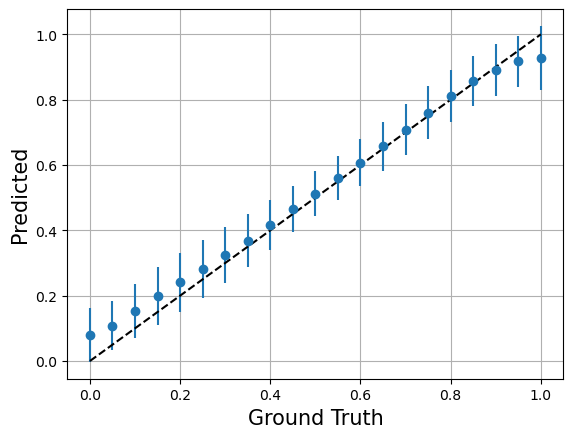

In [7]:
import matplotlib.pyplot as plt

err = all_pred.std(axis=1)
avg_pred = all_pred.mean(axis=1)
_,ax  = plt.subplots()
# plot with error bars
ax.errorbar(gt, avg_pred, yerr=err, fmt='o')
ax.plot(gt,gt, 'k--', color='black')
ax.set_xlabel('Ground Truth', fontsize=15)
ax.set_ylabel('Predicted', fontsize=15)
ax.grid()

In [8]:
mse = ((all_pred - gt.reshape(-1,1))**2).mean(axis=1)
print(f'RMSE: {np.sqrt(mse.mean())}')

RMSE: 0.08743708803255702


In [9]:
inp_std = inp_arr.reshape(len(inp_arr),-1).std(axis=1).mean()
inp_mean = np.mean(inp_arr)

In [10]:
print(inp_mean, inp_std)

-0.79673177 0.16574058


In [11]:
inp_max , inp_min = inp_arr.max(), inp_arr.min()

In [12]:
inp_min

-1.0